# classify wanted adds

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from setfit import SetFitModel, SetFitTrainer
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

2023-02-28 09:34:27.793921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-28 09:34:27.793934: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
 df = pd.read_csv('job_classification.csv').drop(columns='Unnamed: 0').rename(columns={'class_id': 'label'}).dropna()

In [3]:
df.isna().sum()

label          0
title          0
description    0
dtype: int64

In [4]:
#is it balanced
df['label'].value_counts(normalize=True)*100

3    24.221790
0    15.564202
5    15.564202
2    15.515564
4    15.515564
1    13.618677
Name: label, dtype: float64

In [5]:
# there are 6 labels we can use accuracy metric
df['description'].str.split().map(len).describe()


count    2056.000000
mean      484.623054
std       147.511159
min         1.000000
25%       467.750000
50%       544.000000
75%       573.000000
max       669.000000
Name: description, dtype: float64

# WE use SefFit which is a transformer based texct feautred classification

## We concatenate title and description so the model will look at is as whole:

In [6]:
df['text'] = df['title'] + '\n' + df['description']

In [7]:
np.random.seed(22)
train_df, test_df = train_test_split(df, test_size = .2, stratify=df['label'])
train_df['label'].value_counts(normalize=True)
len(train_df), len(test_df)

(1644, 412)

# SetFit

## Since it is a drill and we do not have time, we will train only subsample of data

In [8]:
train_subset, _ = train_test_split(train_df, train_size=200,stratify = train_df['label'])

train_ds = Dataset.from_pandas(train_subset)
test_ds = Dataset.from_pandas(test_df)

In [9]:
# Load SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-MiniLM-L6-v2")

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    batch_size=16,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    column_mapping={"text": "text", "label": "label"},
    num_epochs=1 # Number of epochs to use for contrastive learning
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [10]:
trainer.train()

Applying column mapping to training dataset
***** Running training *****
  Num examples = 8000
  Num epochs = 1
  Total optimization steps = 500
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/500 [00:00<?, ?it/s]

/home/ariels/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
train_df.columns

Index(['label', 'title', 'description', 'text'], dtype='object')

In [12]:
trainer.evaluate()

Applying column mapping to evaluation dataset
***** Running evaluation *****


{'accuracy': 0.720873786407767}

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
test_pred = trainer.model.predict(test_df.reset_index()['text'])
confusion_matrix(test_df['label'], test_pred.reshape(-1,1))


array([[40, 20,  0,  0,  3,  1],
       [29, 24,  0,  0,  3,  0],
       [ 0,  0, 40, 22,  2,  0],
       [ 0,  0, 20, 79,  1,  0],
       [ 0,  0,  0,  1, 57,  6],
       [ 0,  0,  0,  1,  6, 57]])

Text(83.40000000000006, 0.5, 'GT')

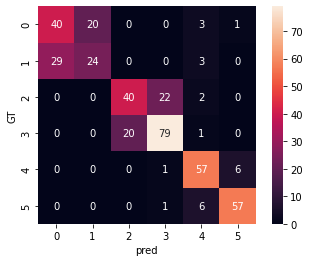

In [15]:
sns.heatmap(confusion_matrix(test_df['label'], test_pred), annot=True, square=True)
plt.xlabel('pred')
plt.ylabel('GT')

In [16]:
# lets find words that are typical for class

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [18]:
vectorizer = TfidfVectorizer(use_idf=False, stop_words='english')

mega_text = train_df.groupby('label')['text'].apply(lambda texts:  '\n'.join(texts))

mega_tf = vectorizer.fit_transform(mega_text)
mega_tf = pd.DataFrame(mega_tf.todense(),columns=vectorizer.get_feature_names_out()).T

pd.DataFrame({
    label: mega_tf[label].sort_values(ascending=False).index
    for label in range(6)
}).head()

,0,1,2,3,4,5
0,health,health,service,work,water,water
1,care,care,work,airport,work,resources
2,experience,services,airport,service,experience,engineering
3,company,experience,company,required,company,experience
4,patient,department,customer,company,service,design


In [19]:
# what are the top 20 words at each class??

In [20]:
train_df.groupby('label')['text'].apply(lambda texts: texts.str.lower().str.contains('water').mean())

label
0    0.011719
1    0.022321
2    0.101961
3    0.057789
4    0.925490
5    0.992188
Name: text, dtype: float64

In [21]:
vectorizer = TfidfVectorizer(use_idf=True, stop_words='english', min_df=5, sublinear_tf=True)

In [25]:
vec_df = vectorizer.fit_transform(train_df['text'])
vec_df = pd.DataFrame(vec_df.todense(), columns = vectorizer.get_feature_names_out())
vec_df

,00,000,001,00am,00pm,01,02,03,04,06,...,year,yearly,years,yes,yield,york,youth,zealand,zone,zones
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.056445,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.057166,0.0,0.051857,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.054875,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.046957,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
from sklearn.feature_selection import chi2

In [36]:
pd.DataFrame({label:
vec_df.columns[np.argsort(chi2(vec_df, train_df['label']==label)[1])]
 for label in range(6)}
            ).head(20)


,0,1,2,3,4,5
0,clinical,health,rent,airport,water,resources
1,patients,patient,enterprise,lax,distribution,hec
2,health,department,car,water,operator,civil
3,patient,nursing,rental,wayne,wastewater,stormwater
4,care,care,hospitality,ramp,meter,engineering
5,hospital,county,airport,aircraft,meters,engineer
6,nursing,mental,guest,health,plant,modeling
7,massachusetts,nurse,lot,john,valves,hydrologic
8,baystate,community,dfw,stand,plants,water
9,therapy,medical,alamo,lift,hydrants,hydraulic


In [91]:
train_df[(~train_df['text'].str.lower().str.contains('wayne'))
        & (train_df['text'].str.lower().str.contains('airport'))]['text'].sample(1).iloc[0]
#Looks there is a geographical issue between class 2 and class 3

'Ramp Agent\nSUMMARY: As an Airport Ramp Agent you will support airlines by overseeing direction of a variety of aircraft ground handling services including, but not limited to ramp, baggage, cabin cleaning services, GSE maintenance, and customer service functions. Essential Duties and Responsibilities of an Airport Ramp Agent - include the following. Other duties may be assigned.  Ensures a safe work environment by following all ATS rules and regulations regarding the work place.  Marshals inbound... aircraft into ramp area of assigned gate.  Unloads passenger baggage, cargo and mail from aircraft bins while plane is parked at the gate on to bag carts.  Delivers loaded bag carts using tugs to bag room and unloads bag cars on to conveyor belt which will bring the bags to the carousals for passenger pick up.  Delivers bag carts of mail to airport post office and picks up loaded carts for out going flights.  Delivers bag carts of cargo to the cargo area and picks up loaded carts for out 

In [125]:
train_df[(~train_df['text'].str.lower().str.contains('airport'))
        &(train_df['label']==2)]['text'].sample(1).iloc[0]
# it seems airport in class 3 are californian located while class 2 are at other outside of california

'General Manager\nDescription Job Duties & Essential Functions The GM is responsible for the overall management and operation of the hotel including profitability, guest service, quality, and overall cleanliness & maintenance of the property  Lead the Executive and Management team effectively.  Plans, develops and implements hotel policies and goals.  Coordinates activities of departments such as rooms, food, beverage, engineering, sales, and administrative to create operational efficiency and economy. ... Directs and coordinates promotion of products and services to develop new markets, increase share of market, and obtain a competitive position in the industry.  Analyzes department budget requests to identify areas in which reductions can be made and allocates operating budget.  Confers with personnel and reviews activity, operating and sales reports to determine changes in programs or operations required.  Directs preparation of directives to departments outlining policy, program, o